In [1]:
import numpy as np
import pywt
import librosa 
import os
from data import WaveData, SR
import matplotlib.pyplot as plt
import tqdm
import soundfile as sf

# Import a test dataset

DATA_PATH = 'data/scott_one_song_moises/songs/'
PERM_FOLDERS = os.listdir(DATA_PATH)
print(PERM_FOLDERS)

def get_perms(data_path=DATA_PATH, perm_folders=PERM_FOLDERS, sr=SR):
    perms = []
    data = {}
    print(perm_folders)
    for folder in perm_folders:
        if folder == '.DS_Store':
            continue
        print(folder)
        # called folder/Test -> read the Test part with librosa
        if 'Test' in os.listdir(data_path + folder):
            
            
            for song in os.listdir(data_path + folder + '/Test'):
            
                perms.append(song)

                if song == '.DS_Store':
                    continue
                
                waveform, sr = librosa.load(data_path + folder + '/Test/' + song, mono=False, sr=sr)
                # print(waveform.shape)
                waveform = np.transpose(waveform)
                # print(waveform.shape)
                data[song] = WaveData(song, waveform, None)
            
    return perms, data

perms, TRAIN_DATA = get_perms()


['song_bass1_drums1_piano1', '.DS_Store', 'song_piano1_vocals1', 'song_bass1_guitar1_piano1', 'song_bass1_drums1', 'song_drums1_guitar1_piano1', 'song_bass1_drums1_guitar1_vocals1', 'song_drums1_piano1']
['song_bass1_drums1_piano1', '.DS_Store', 'song_piano1_vocals1', 'song_bass1_guitar1_piano1', 'song_bass1_drums1', 'song_drums1_guitar1_piano1', 'song_bass1_drums1_guitar1_vocals1', 'song_drums1_piano1']
song_bass1_drums1_piano1
song_piano1_vocals1
song_bass1_guitar1_piano1
song_bass1_drums1
song_drums1_guitar1_piano1
song_bass1_drums1_guitar1_vocals1
song_drums1_piano1


In [2]:

# Get song length analytics

def length_analysis(perms=perms, data=TRAIN_DATA):
    lengths = []
    for song in perms:
        try:
            lengths.append(data[song].waveform.shape[0])
        except Exception as e:
            print(e)
            print(song)
    return lengths

def print_length_analytics(lengths):
    print('Max length:', max(lengths))
    print('Min length:', min(lengths))
    print('Mean length:', np.mean(lengths))
    print('Median length:', np.median(lengths))
    # graph of distribution
    plt.hist(lengths, bins=20)
    plt.show()

lengths = length_analysis()
# print_length_analytics(lengths)

In [ ]:
# TODO: Remove songs above a certain length


0it [00:00, ?it/s]

[4577241, 4577241, 4577241, 4577241]
Tensor coefficients shape: (4, 4577241, 1)


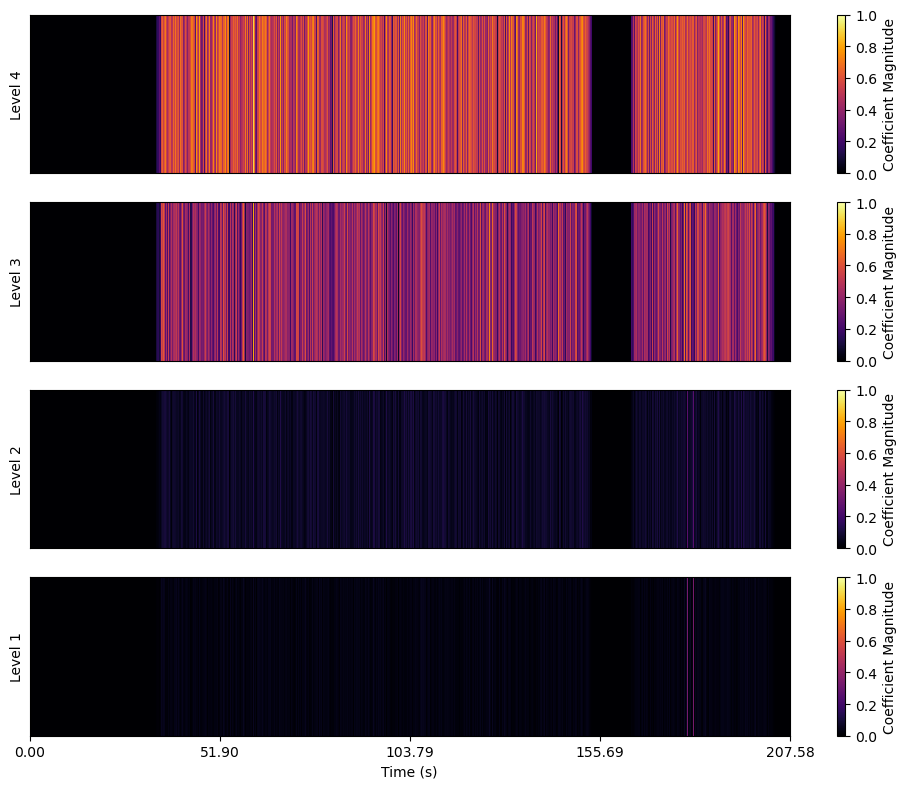

1it [00:00,  2.51it/s]


In [28]:
import tensorflow as tf

def get_wavelet_transform(data=TRAIN_DATA):
    for i, song in tqdm.tqdm(enumerate(perms)):
        if i > 0:
            break
        # Perform wavelet decomposition
        coeffs = pywt.wavedec2(data[song].waveform, 'db1')
        
        # Convert coefficients to a list of numpy arrays
        coeffs_list = [coeffs[0]] + list(coeffs[1])
        
        # Pad the coefficient arrays to have the same length
        print([len(arr) for arr in coeffs_list])
        max_length = max(len(arr) for arr in coeffs_list)
        padded_coeffs = [np.pad(arr, ((0, max_length - len(arr)), (0, 0)), 'constant') for arr in coeffs_list]
        
        # Stack the padded coefficients into a single array
        stacked_coeffs = np.stack(padded_coeffs, axis=0)
        
        # Convert the stacked coefficients to a TensorFlow tensor
        tensor_coeffs = tf.convert_to_tensor(stacked_coeffs)
        
        print(f"Tensor coefficients shape: {tensor_coeffs.shape}")
        
        data[song].dwt = coeffs
        data[song].tensor_coeffs = tensor_coeffs
        
        visualize_wavelet(data[song])
    
    return data

def visualize_wavelet(wd, sr=44100):
    levels = wd.tensor_coeffs.shape[0]
    channels = wd.tensor_coeffs.shape[-1]
    time_steps = wd.tensor_coeffs.shape[1]
    
    # Calculate the duration of the song
    duration = len(wd.waveform) / sr
    
    fig, axs = plt.subplots(levels, channels, figsize=(10, 2*levels))
    
    for ch in range(channels):
        for i in range(levels):
            ax = axs[i, ch] if channels > 1 else axs[i]
            
            # Get the coefficients for the current level and channel
            coeffs = wd.tensor_coeffs[i, :, ch].numpy()
            
            # Normalize the coefficients for visualization
            coeffs = np.abs(coeffs)
            coeffs /= np.max(coeffs)
            
            # Plot the coefficients as a heatmap with log scaling
            im = ax.imshow(np.sqrt(np.sqrt(coeffs.reshape(1, -1))), cmap='inferno', aspect='auto', interpolation='nearest', vmin=0, vmax=1)
            
            # Set the y-tick labels to represent the levels
            ax.set_yticks([])
            ax.set_ylabel(f"Level {levels-i}")
            
            # Set the x-label and x-ticks
            if i == levels - 1:
                ax.set_xlabel("Time (s)")
                ax.set_xticks(np.linspace(0, time_steps, 5))
                ax.set_xticklabels([f"{t:.2f}" for t in np.linspace(0, duration, 5)])
            else:
                ax.set_xticks([])
            
            # Add a colorbar
            if ch == channels - 1:
                cbar = fig.colorbar(im, ax=ax)
                cbar.set_label("Coefficient Magnitude")
    
    plt.tight_layout()
    plt.show()


TRAIN_DATA = get_wavelet_transform()




# Pad up to max dims -- print dims
# def pad_dwt(data=TRAIN_DATA):
#     max_shape = None
#     for song in perms:
#         if max_shape is None:
#             max_shape = data[song].npdwt.shape
#         else:
#             max_shape = np.maximum(max_shape, data[song].npdwt.shape)

#     new_dwt = np.zeros_like(max_shape)
#     for song in perms:
#         # pad the dwt
#         # print(new_wavedata.dwt.shape)
#         pad_width = [(0, max_shape[0] - data[song].npdwt.shape[0])]
#         for i in range(1, len(max_shape)):
#             pad_width.append((0, max_shape[i] - data[song].npdwt.shape[i]))
#         new_dwt = np.pad(data[song].npdwt, pad_width, mode='constant', constant_values=0)
#         data[song].npdwt = new_dwt
#         print(new_dwt.shape)
#     return data

# TRAIN_DATA = pad_dwt()
# save the numpy file to song folder

In [29]:
# try idwt to see if it works
def idwt(data=TRAIN_DATA):
    idwts = []
    for i, song in tqdm.tqdm(enumerate(perms)):
        # convert to  (list, tuple) from numpy array
        idwt = pywt.waverec2(data[song].dwt, 'db1')
        idwts.append(idwt)
    return idwts

idwts = idwt()
print(idwts[0].shape)

# save the idwt to a file\
import soundfile as sf
def save_idwt(data=TRAIN_DATA, idwts=idwts):
    song = perms[0]
    sf.write('idwt.wav', idwts[0], SR)

save_idwt()


13it [00:01,  8.46it/s]


(9154482, 2)
